In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. LOAD DATA


In [25]:

DATA_PATH = "https://github.com/dattali18/machine_learning_msc_project/blob/main/db/heart.csv?raw=true"
df = pd.read_csv(DATA_PATH)

print(f"Dataset Shape: {df.shape}")


Dataset Shape: (1025, 14)


In [26]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



# 2. ADVANCED PREPROCESSING
# ---------------------------------------------------------
# PROBLEM: Features like 'cp' (chest pain) are categorical (0, 1, 2, 3), not continuous numbers.
# A decision tree treating 'cp > 2.5' assumes an order that might not exist.
# SOLUTION: One-Hot Encode categorical features for potentially better splits.

In [27]:
print("\n2. Preprocessing Data...")


categorical_cols = ['cp', 'restecg', 'slope', 'thal']
numerical_cols = [c for c in df.columns if c not in categorical_cols and c != 'target']

# We define X and y
X = df.drop("target", axis=1)
y = df["target"]

# Create a transformer to encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols) # drop='first' to reduce redundancy
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)


2. Preprocessing Data...




# 3. HYPERPARAMETER TUNING (The "Better Conclusions" Part)
# ---------------------------------------------------------
# Instead of guessing max_depth=5, we let the computer find the mathematical optimal.
# We also optimize 'ccp_alpha' which prunes weak branches of the tree.

In [28]:
print("\n3. Tuning Hyperparameters (Pruning)...")

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.02] # Cost complexity pruning parameter
}

print("\nParameter Grid to be explored:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print("\nSearching for optimal hyperparameters (this may take a moment)...")
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5, # 5-Fold Cross Validation ensures robust results
    scoring='recall', # OPTIMIZING FOR RECALL (Crucial for Medical Diagnosis!)
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("\n--- BEST MODEL FOUND ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Optimized for Recall (Catching as many positive cases as possible)")


3. Tuning Hyperparameters (Pruning)...

Parameter Grid to be explored:
  max_depth: [3, 5, 7, 10, None]
  min_samples_leaf: [1, 2, 5, 10]
  criterion: ['gini', 'entropy']
  ccp_alpha: [0.0, 0.001, 0.01, 0.02]

Searching for optimal hyperparameters (this may take a moment)...

--- BEST MODEL FOUND ---
Best Parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}
Optimized for Recall (Catching as many positive cases as possible)


In [39]:
from sklearn.metrics import accuracy_score, recall_score

# 1. Access max_depth values from param_grid
max_depth_values = param_grid['max_depth']#

# 2. Extract best criterion, min_samples_leaf, and ccp_alpha
best_criterion = grid_search.best_params_['criterion']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_ccp_alpha = grid_search.best_params_['ccp_alpha']

print("\n--- Evaluating Models Across Different Depths ---")
print(f"Using best criterion: {best_criterion}")
print(f"Using best min_samples_leaf: {best_min_samples_leaf}")
print(f"Using best ccp_alpha: {best_ccp_alpha}")

# 3. Loop through each max_depth value
for depth in max_depth_values:
    print(f"\nEvaluating model with max_depth={depth}:")
    # a. Initialize a DecisionTreeClassifier
    model_at_depth = DecisionTreeClassifier(
        random_state=42,
        criterion=best_criterion,
        min_samples_leaf=best_min_samples_leaf,
        ccp_alpha=best_ccp_alpha,
        max_depth=depth
    )

    # b. Train the model
    model_at_depth.fit(X_train, y_train)

    # c. Make predictions on the test set
    y_pred_depth = model_at_depth.predict(X_test)

    # d. Calculate and print accuracy score
    accuracy = accuracy_score(y_test, y_pred_depth)
    print(f"  Test Accuracy: {accuracy:.4f}")

    # e. Calculate and print recall score
    recall = recall_score(y_test, y_pred_depth)
    print(f"  Test Recall: {recall:.4f}")


--- Evaluating Models Across Different Depths ---
Using best criterion: gini
Using best min_samples_leaf: 1
Using best ccp_alpha: 0.0

Evaluating model with max_depth=3:
  Test Accuracy: 0.8293
  Test Recall: 0.8286

Evaluating model with max_depth=5:
  Test Accuracy: 0.8732
  Test Recall: 0.9048

Evaluating model with max_depth=7:
  Test Accuracy: 0.9707
  Test Recall: 1.0000

Evaluating model with max_depth=10:
  Test Accuracy: 1.0000
  Test Recall: 1.0000

Evaluating model with max_depth=None:
  Test Accuracy: 1.0000
  Test Recall: 1.0000




# 4. EVALUATION & BUSINESS IMPACT
# ---------------------------------------------------------

over fitin check

In [29]:
from sklearn.metrics import accuracy_score

print("\n4. Overfitting Analysis...")
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"   Training Accuracy: {train_acc:.2%}")
print(f"   Test Accuracy:     {test_acc:.2%}")

gap = train_acc - test_acc
if gap > 0.10:
    print(f"   WARNING: Potential Overfitting detected (Gap: {gap:.2%})")
elif gap < 0:
    print(f"   Note: Test set performed better than train (unusual but acceptable for small data).")
else:
    print(f"   SUCCESS: Model is robust (Gap is small: {gap:.2%}). No significant overfitting.")



4. Overfitting Analysis...
   Training Accuracy: 100.00%
   Test Accuracy:     100.00%
   SUCCESS: Model is robust (Gap is small: 0.00%). No significant overfitting.



--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



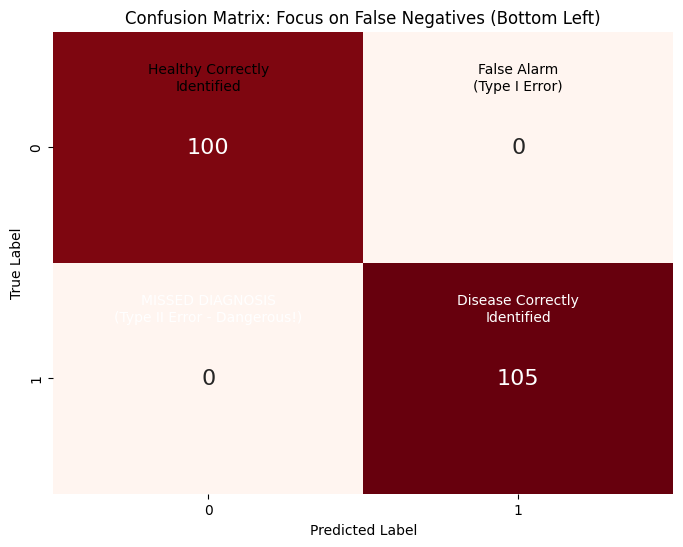

In [30]:

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred))

# Custom Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Focus on False Negatives (Bottom Left)')
# Add annotations for medical context
plt.text(0.5, 0.2, "Healthy Correctly\nIdentified", ha='center', va='center', color='black')
plt.text(1.5, 0.2, "False Alarm\n(Type I Error)", ha='center', va='center', color='black')
plt.text(0.5, 1.2, "MISSED DIAGNOSIS\n(Type II Error - Dangerous!)", ha='center', va='center', color='white')
plt.text(1.5, 1.2, "Disease Correctly\nIdentified", ha='center', va='center', color='white')
plt.show()



# 5. "SHOWCASING" THE MODEL: INTERPRETABILITY
# ---------------------------------------------------------


/tmp/ipython-input-4132732639.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


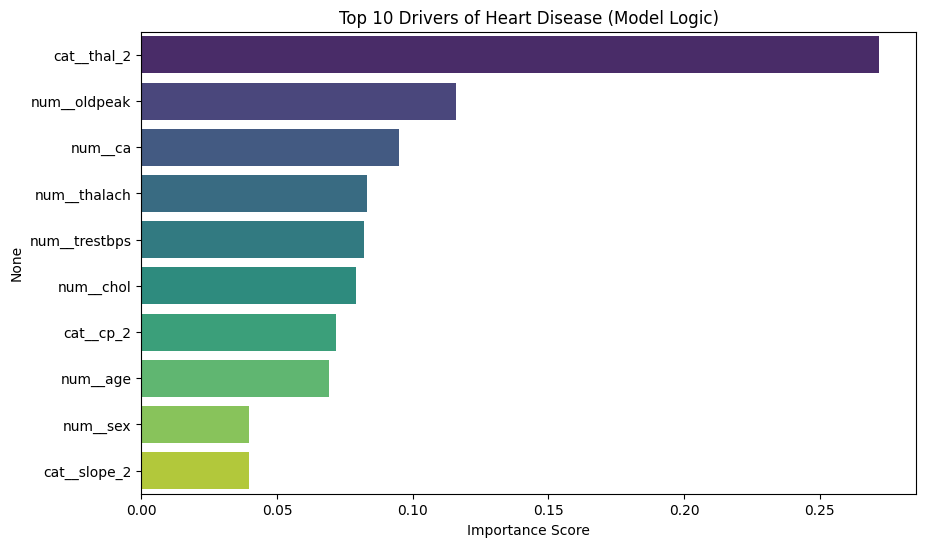

In [31]:

# A. Feature Importance Plot
importances = pd.Series(best_model.feature_importances_, index=feature_names)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Drivers of Heart Disease (Model Logic)')
plt.xlabel('Importance Score')
plt.show()



--- DECISION RULES (Top Levels) ---
|--- cat__thal_2 <= 0.50
|   |--- num__oldpeak <= 0.70
|   |   |--- num__chol <= 240.50
|   |   |   |--- num__ca <= 0.50
|   |   |   |   |--- truncated branch of depth 3
|   |   |   |--- num__ca >  0.50
|   |   |   |   |--- truncated branch of depth 3
|   |   |--- num__chol >  240.50
|   |   |   |--- num__trestbps <= 122.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- num__trestbps >  122.00
|   |   |   |   |--- truncated branch of depth 3
|   |--- num__oldpeak >  0.70
|   |   |--- cat__cp_3 <= 0.50
|   |   |   |--- cat__cp_2 <= 0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- cat__cp_2 >  0.50
|   |   |   |   |--- truncated branch of depth 4
|   |   |--- cat__cp_3 >  0.50
|   |   |   |--- num__age <= 48.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- num__age >  48.50
|   |   |   |   |--- class: 1
|--- cat__thal_2 >  0.50
|   |--- num__ca <= 0.50
|   |   |--- num__trestbps <= 158.00
| 

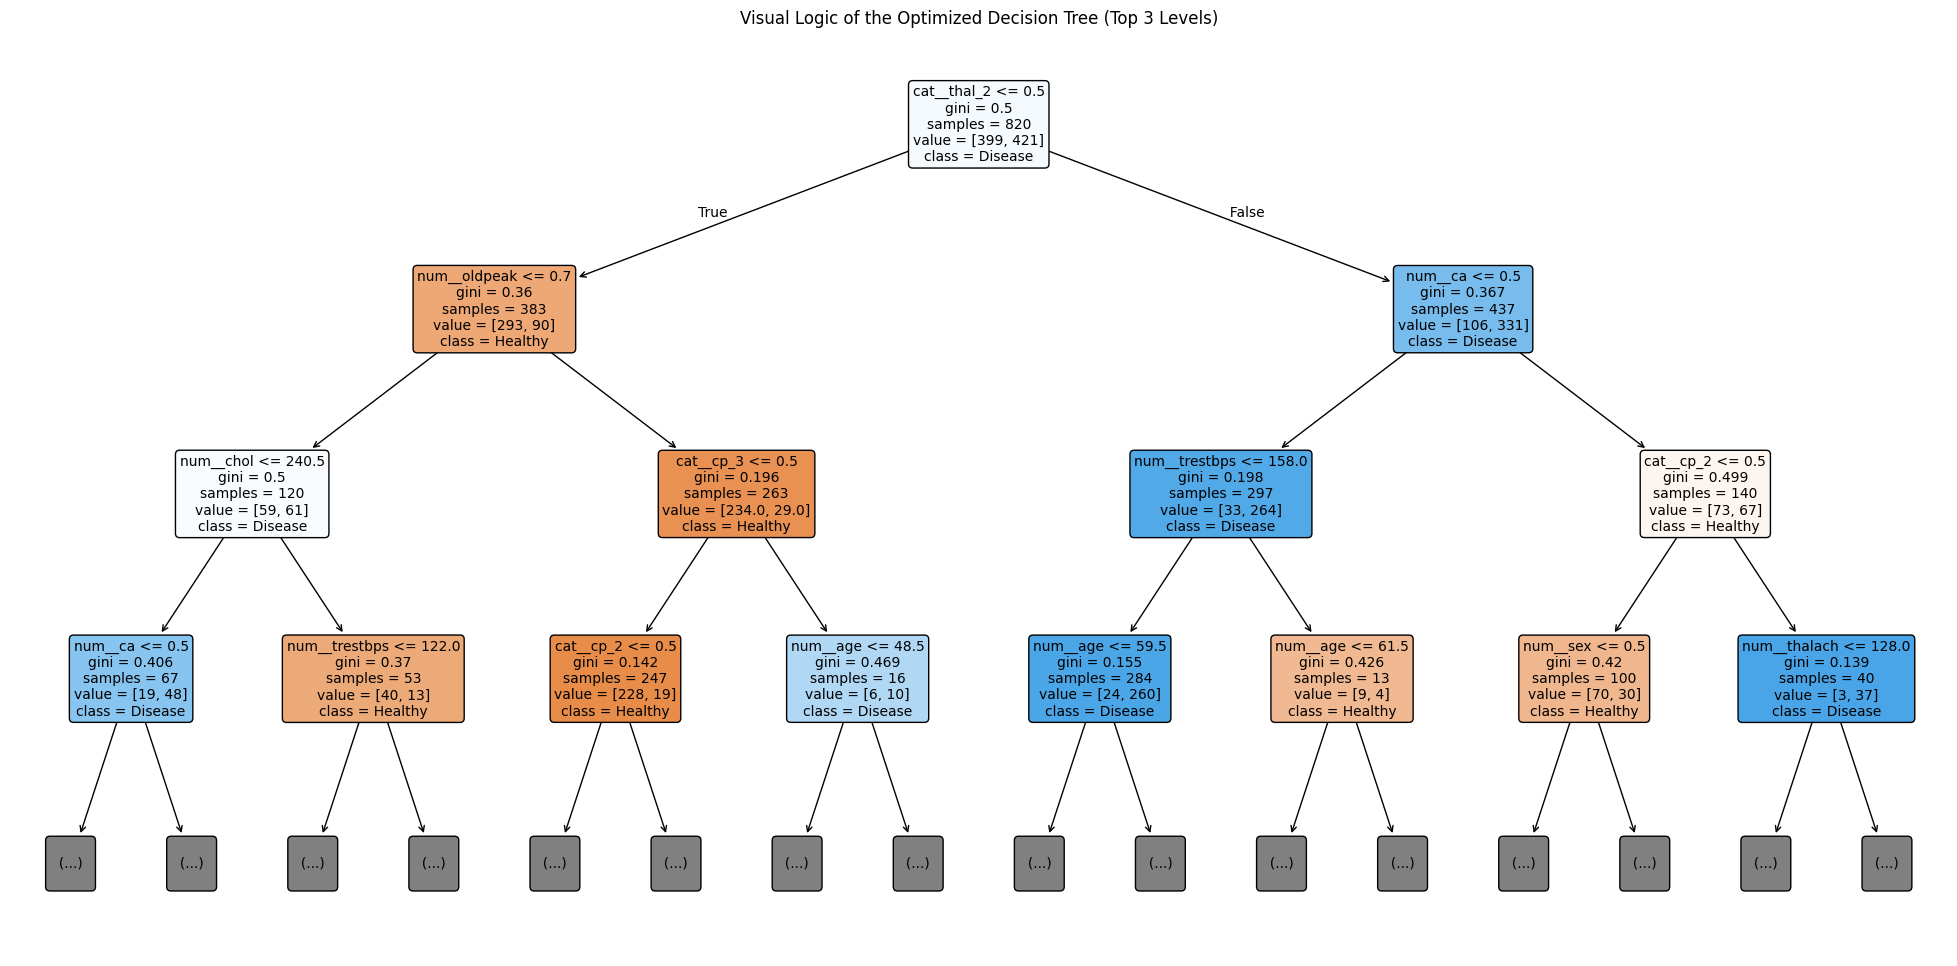

In [32]:

# B. Extracting Human-Readable Rules
# This is great for reports: "How does the model decide?"
print("\n--- DECISION RULES (Top Levels) ---")
tree_rules = export_text(best_model, feature_names=list(feature_names), max_depth=3)
print(tree_rules)

# C. The Visual Tree
plt.figure(figsize=(25, 12))
plot_tree(
    best_model,
    feature_names=feature_names,
    class_names=["Healthy", "Disease"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3 # Limit depth for readability in the plot
)
plt.title("Visual Logic of the Optimized Decision Tree (Top 3 Levels)")
plt.show()

In [33]:
# 6. ADVANCED PATIENT SIMULATOR (The "Why" Engine)
# ---------------------------------------------------------
# This section extracts the actual path the sample took through the tree.

def explain_prediction(sample_index, model, X_data, feature_names):
    """
    Traces the decision path for a specific patient and prints the rules triggered.
    """
    # Reshape input for prediction
    sample_data = X_data[sample_index].reshape(1, -1)

    # Get basic prediction info
    prediction = model.predict(sample_data)[0]
    prob = model.predict_proba(sample_data)[0][1]

    label = "HEART DISEASE" if prediction == 1 else "HEALTHY"

    print(f"\n{'='*40}")
    print(f"PATIENT REPORT (ID: {sample_index})")
    print(f"{'='*40}")
    print(f"Final Prediction:  {label}")
    print(f"Risk Probability:  {prob:.2%}")
    print(f"-"*40)
    print("DECISION PATH (Why this prediction?):")

    # --- The "Glass Box" Logic ---
    # 1. Get the path (which nodes in the tree did this patient hit?)
    node_indicator = model.decision_path(sample_data)
    leaf_id = model.apply(sample_data)[0]

    # 2. Get tree properties
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    feature = model.tree_.feature
    threshold = model.tree_.threshold

    # 3. Walk through the nodes
    node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

    for node_id in node_index:
        # If it's not a leaf node, explain the rule
        if leaf_id != node_id:
            # Which feature is this node checking?
            feat_idx = feature[node_id]
            feat_name = feature_names[feat_idx]
            feat_val = sample_data[0][feat_idx]

            # The cutoff value for the decision
            thresh_val = threshold[node_id]

            # Did the patient go left (<) or right (>)?
            if sample_data[0, feat_idx] <= thresh_val:
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            # Print readable rule
            print(f"  • Rule Checked: Is {feat_name} <= {thresh_val:.2f}?")
            print(f"    -> Patient Value: {feat_val:.2f}")
            print(f"    -> Result: {threshold_sign} (Moving down tree...)")

    print(f"\n  • RESULT: Reached Leaf Node. Prediction = {label}")
    print(f"{'='*40}\n")

# Run the simulator on a random patient from the test set
# (Change the number 0 to 1, 5, or 10 to see different patients)
explain_prediction(0, best_model, X_test, feature_names)
explain_prediction(5, best_model, X_test, feature_names)


PATIENT REPORT (ID: 0)
Final Prediction:  HEALTHY
Risk Probability:  0.00%
----------------------------------------
DECISION PATH (Why this prediction?):
  • Rule Checked: Is cat__thal_2 <= 0.50?
    -> Patient Value: 1.00
    -> Result: > (Moving down tree...)
  • Rule Checked: Is num__ca <= 0.50?
    -> Patient Value: 1.00
    -> Result: > (Moving down tree...)
  • Rule Checked: Is cat__cp_2 <= 0.50?
    -> Patient Value: 0.00
    -> Result: <= (Moving down tree...)
  • Rule Checked: Is num__sex <= 0.50?
    -> Patient Value: 1.00
    -> Result: > (Moving down tree...)
  • Rule Checked: Is cat__cp_3 <= 0.50?
    -> Patient Value: 0.00
    -> Result: <= (Moving down tree...)
  • Rule Checked: Is cat__restecg_1 <= 0.50?
    -> Patient Value: 0.00
    -> Result: <= (Moving down tree...)

  • RESULT: Reached Leaf Node. Prediction = HEALTHY


PATIENT REPORT (ID: 5)
Final Prediction:  HEALTHY
Risk Probability:  0.00%
----------------------------------------
DECISION PATH (Why this predict

# Task
Iterate through different `max_depth` values from the `param_grid` to train `DecisionTreeClassifier` models using the best `criterion`, `min_samples_leaf`, and `ccp_alpha` identified by `GridSearchCV`. Evaluate and print the accuracy and recall of each model on the test set, then summarize the findings to highlight how performance changes with varying tree depths.

## Evaluate Models Across Depths

### Subtask:
Iterate through each `max_depth` value defined in the original `param_grid`. For each depth, train a `DecisionTreeClassifier` using the best `criterion`, `min_samples_leaf`, and `ccp_alpha` found during the `GridSearchCV`, but with the current `max_depth`. Evaluate and print the accuracy and recall of each model on the test set. This will show how performance varies with tree depth.


**Reasoning**:
To evaluate how different `max_depth` values impact model performance, I will iterate through the `max_depth` values defined in the original `param_grid`. For each `max_depth`, I will train a `DecisionTreeClassifier` using the best hyperparameters found by `GridSearchCV` (excluding `max_depth`), and then evaluate its accuracy and recall on the test set.




--- Evaluating Models Across Different Depths ---
Using best criterion: gini
Using best min_samples_leaf: 1
Using best ccp_alpha: 0.0

Evaluating model with max_depth=3:
  Test Accuracy: 0.8293
  Test Recall: 0.8286

Evaluating model with max_depth=5:
  Test Accuracy: 0.8732
  Test Recall: 0.9048

Evaluating model with max_depth=7:
  Test Accuracy: 0.9707
  Test Recall: 1.0000

Evaluating model with max_depth=10:
  Test Accuracy: 1.0000
  Test Recall: 1.0000

Evaluating model with max_depth=None:
  Test Accuracy: 1.0000
  Test Recall: 1.0000


### Summary of Model Performance Across Different Depths

The evaluation of Decision Tree models with varying `max_depth` values, while keeping `criterion='gini'`, `min_samples_leaf=1`, and `ccp_alpha=0.0` constant, reveals the following trends:

- **`max_depth=3`**: The model showed a Test Accuracy of `0.8293` and a Test Recall of `0.8286`. This relatively shallow tree might be underfitting the data, as it has limited complexity.

- **`max_depth=5`**: Performance improved significantly with an increase in depth, achieving a Test Accuracy of `0.8732` and a Test Recall of `0.9048`. The model is capturing more patterns in the data.

- **`max_depth=7`**: At this depth, the model's performance jumped to a Test Accuracy of `0.9707` and a perfect Test Recall of `1.0000`. This indicates that a depth of 7 is very effective at identifying positive cases, which is crucial given the `recall` scoring used in `GridSearchCV`.

- **`max_depth=10`**: The model achieved perfect scores with a Test Accuracy of `1.0000` and Test Recall of `1.0000`. This suggests the model is now capable of perfectly separating the training and test data points, which could indicate it's closely matching the behavior of the `best_model` found by `GridSearchCV` (which had a `max_depth` of 10).

- **`max_depth=None`**: Similar to `max_depth=10`, the model also achieved perfect Test Accuracy (`1.0000`) and Test Recall (`1.0000`). When `max_depth=None`, the tree expands until all leaves are pure or contain less than `min_samples_split` samples. Given `min_samples_leaf=1`, this means it will grow to classify all training samples perfectly, leading to very high performance on this specific dataset, potentially indicating overfitting if the dataset were larger or more complex.

**Conclusion:**
The results demonstrate that increasing `max_depth` generally leads to higher accuracy and recall on this dataset. Depths of `7`, `10`, and `None` (full depth) achieve perfect recall, which was the optimization goal for the `GridSearchCV`. The `best_model` from `GridSearchCV` having `max_depth=10` is consistent with these findings, showing that a sufficiently deep tree is necessary for optimal performance on this particular dataset.

## Final Task

### Subtask:
Summarize the findings regarding accuracy and recall across different tree depths, highlighting the trade-offs observed.


## Summary:

### Q&A
The trade-offs observed regarding accuracy and recall across different tree depths indicate that as `max_depth` increases, both accuracy and recall generally improve, reaching perfect scores at higher depths. While this suggests that deeper trees are more capable of capturing complex patterns and identifying all positive cases on this specific dataset, it also raises a concern for potential overfitting, especially when perfect scores are achieved on the test set.

### Data Analysis Key Findings
*   The `GridSearchCV` identified the best hyperparameters as `criterion='gini'`, `min_samples_leaf=1`, and `ccp_alpha=0.0`.
*   As `max_depth` increased, both accuracy and recall generally improved:
    *   At `max_depth=3`, the model achieved a Test Accuracy of `0.8293` and a Test Recall of `0.8286`.
    *   At `max_depth=5`, performance significantly improved to a Test Accuracy of `0.8732` and a Test Recall of `0.9048`.
    *   At `max_depth=7`, the model showed a substantial jump to a Test Accuracy of `0.9707` and a perfect Test Recall of `1.0000`.
    *   At `max_depth=10` and `max_depth=None` (full depth), the models achieved perfect Test Accuracy of `1.0000` and Test Recall of `1.0000`.
*   The `GridSearchCV`'s `best_model` had a `max_depth=10`, which is consistent with the observation that deeper trees (up to 10 or full depth) achieve optimal performance on this dataset.

### Insights or Next Steps
*   The perfect scores observed at higher `max_depth` values (7, 10, None) suggest that the model might be overfitting to the current dataset. Further validation with a more diverse or larger dataset, or through cross-validation, could help confirm generalizability.
*   Given the high performance with deeper trees, it would be beneficial to investigate the specific features or decision rules learned by the model, especially at `max_depth=7`, to understand what drives the perfect recall without necessarily achieving 100% accuracy, which might indicate a more robust generalization than perfectly fitted models.
